In [1]:
import pandas as pd
from  more_itertools import unique_everseen
import codecs
import re
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm as tq
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def list_to_file(filepath, list_, codec):
    with codecs.open(filepath, 'w', codec) as file:
        for line in list_:
            line = line + '\n'
            file.write(line)
            
def read_list(filepath, codec):
    with codecs.open(filepath, 'r', codec) as file:
        data = file.readlines()
        data = [line.rstrip() for line in data]
    return data

def recursive_flatten_generator(array):
    lst = []
    for i in array:
        if isinstance(i, list):
            lst.extend(recursive_flatten_generator(i))
        else:
            lst.append(i)
    return lst

def normalize_corp(corp_list):
    norm_corp = []
    for item in corp_list:
        words = re.split('\W+', item)
        norm_word = [morph.parse(word)[0].normal_form for word in words]
        norm_corp.append(norm_word)
    norm_corp = [" ".join(item) for item in norm_corp]
    return norm_corp

In [3]:
data = pd.read_csv('../_data/patients_with operations_dataset_clean.txt', encoding='cp1251', sep='\t', engine='python', header=None, error_bad_lines=False,parse_dates=[3])
data.columns = ['index', 'patient', 'episode','date', 'time','clinitian', 'depart', 'hosp','specialty','appoint','document','text','vyp']
oper_to_mod = read_list('../_data/oper_to_mod.txt','utf-8') #Операции от Дмитрия
intra_docs = read_list('../_data/intra_docs.txt','utf-8')
data['text'] = data.apply(lambda x: re.sub(r'293pan\d+', '', x['text']), axis=1)
data['text'] = data.apply(lambda x: re.sub(r'10sup\d+', '', x['text']), axis=1)
data['text'] = data.apply(lambda x: re.sub(r'\s+', ' ', x['text']), axis=1)
data['text'] = data.apply(lambda x: re.sub(r'293t\d+', '', x['text']), axis=1)
data.head()


,index,patient,episode,date,time,clinitian,depart,hosp,specialty,appoint,document,text,vyp
0,0,GACAAGc,GACAAGcAAAAIe10:30-uAA,2009-03-18,10:30b 11:00,Наумова_Людмила_Васильевна,Кар,Центр_Алмазова,Врач-кардиолог,"Прием_(осмотр,_консультация)_врача-кардиолога_...",ДИАГНОЗ_АМБУЛАТОРНЫЙ,ДИАГНОЗ_ПРЕДВАРИТЕЛЬНЫЙ_ОСНОВНОЙ I20.8 Другие ...,выполнено
1,1,GACAAGc,GACAAGcAAAAIxN20288uAA,2009-04-06,10:55,Наумова_Людмила_Васильевна,Кар,Центр_Алмазова,Врач-кардиолог,"Прием_(осмотр,_консультация)_врача-кардиолога_...",ДИАГНОЗ_АМБУЛАТОРНЫЙ,ДИАГНОЗ_ПРЕДВАРИТЕЛЬНЫЙ_ОСНОВНОЙ I20.8 Другие ...,выполнено
2,2,GACAAGc,GACAAGcAAAAIxN20288{AD,2009-04-06,10:55,Наумова_Людмила_Васильевна,Кар,Центр_Алмазова,Врач-кардиолог,"Прием_(осмотр,_консультация)_врача-кардиолога_...",РЕКОМЕНДАЦИИ,"Липидный спектр, калий, креатинин, МНО, сахар,...",выполнено
3,3,GACAAGc,GACAAGcAAAAJN15:00-iAD,2009-04-22,15:00-15:30,Дзюбенко_Наталья_Александровна,ФД,Центр_Алмазова,Врач_ультразвуковой_диагностики,Эхокардиография,ЭХОКАРДИОГРАФИЧЕСКОЕ_ИССЛЕДОВАНИЕ_РЕЗУЛЬТАТ,"ЧСС 64 уд.в мин., Ритм синусовый",выполнено
4,4,GACAAGc,GACAAGcAAAAJN15:00-iAG,2009-04-22,15:00-15:30,Дзюбенко_Наталья_Александровна,ФД,Центр_Алмазова,Врач_ультразвуковой_диагностики,Эхокардиография,ЭХОКАРДИОГРАФИЧЕСКОЕ_ИССЛЕДОВАНИЕ_РЕЗУЛЬТАТ,"Аорта 41 мм стенки уплотнены ,диаметр расшире...",выполнено


In [4]:
intra_docs

['ПРОТОКОЛ_ОПЕРАЦИИ.',
 'ПРОТОКОЛ_ОПЕРАЦИИ',
 'ПРОТОКОЛ_ОПЕРАЦИИ_НА_СЕРДЦЕ',
 'ПРОТОКОЛ_ОПЕРАЦИИ_(ИМПЛАНТАЦИЯ_ИКД) первичная без смены ИКД',
 'ПРОТОКОЛ_ОПЕРАЦИИ_(ИМПЛАНТАЦИЯ_ЭКС) первичная без смены ЭКС',
 'ПРОТОКОЛ_ОПЕРАЦИИ_(НА_СРЕДОСТЕНИИ)',
 'ОПЕРАЦИЯ_НА_СОСУДАХ_ШЕИ._КАРОТИДНАЯ_ЭНДАТЕРЭКТОМИЯ',
 'ОПЕРАЦИЯ_АРИТМОЛОГИЧЕСКАЯ_(ИМПЛАНТАЦИЯ_УСТРОЙСТВ)',
 'ОПЕРАЦИЯ_АРИТМОЛОГИЧЕСКАЯ_(РЧ/РЧА)',
 'ПРОТОКОЛ_ОПЕРАЦИИ_ЗАМЕСТИТЕЛЬНОЙ_ПОЧЕЧНОЙ_ТЕРАПИИ',
 'ПРОТОКОЛ_ОПЕРАЦИИ_(РЧА)',
 'ПРОТОКОЛ_ОПЕРАЦИИ_(РЕВИЗИЯ)',
 'ПРОТОКОЛ_ОПЕРАЦИИ_ЗАМЕСТИТЕЛЬНОЙ_ПОЧЕЧНОЙ_ТЕРАПИИ_(MPS+PE)',
 'ПРОТОКОЛ_ИНТРАОПЕРАЦИОННОГО_НЕЙРОФИЗИОЛОГИЧЕСКОГО_МОНИТОРИНГА',
 'ПРОТОКОЛ_ОПЕРАЦИИ_ЭНДОПРОТЕЗИРОВАНИЕ_АОРТЫ']

In [5]:
oper_data = data.loc[data['appoint'].isin(oper_to_mod)] #Выделяем только нужные операции
oper_data = oper_data.loc[data['document'].isin(intra_docs)] #Выделяем только нужные операции

In [6]:
oper_data.document.value_counts()

ПРОТОКОЛ_ОПЕРАЦИИ.                            1427
ПРОТОКОЛ_ОПЕРАЦИИ_НА_СЕРДЦЕ                   1190
ПРОТОКОЛ_ОПЕРАЦИИ                              828
ПРОТОКОЛ_ОПЕРАЦИИ_ЭНДОПРОТЕЗИРОВАНИЕ_АОРТЫ      78
Name: document, dtype: int64

In [7]:
#Количество пациентов
len(list(unique_everseen(oper_data.patient)))

455

In [8]:
oper_data.head()

,index,patient,episode,date,time,clinitian,depart,hosp,specialty,appoint,document,text,vyp
359,404,GACAAGc,GACAAGcAARAAP13:17AaAD,2013-12-17,13:17,Артюшин_Борис_Сергеевич,НИЛСХ,Центр_Алмазова,Старший_научный_сотрудник_(в_области_медицины),Резекция_аневризмы_и_протезирование_аорты,ПРОТОКОЛ_ОПЕРАЦИИ.,основная_ведущая Операция РЕЗЕКЦИЯ ИНФРАРЕНАЛЬ...,выполнено
360,405,GACAAGc,GACAAGcAARAAP13:17AaAG,2013-12-17,13:17,Артюшин_Борис_Сергеевич,НИЛСХ,Центр_Алмазова,Старший_научный_сотрудник_(в_области_медицины),Резекция_аневризмы_и_протезирование_аорты,ПРОТОКОЛ_ОПЕРАЦИИ.,Описание операции Выполнен доступ к абдоминал...,выполнено
361,406,GACAAGc,GACAAGcAARAAP13:17AaAJ,2013-12-17,13:17,Артюшин_Борис_Сергеевич,НИЛСХ,Центр_Алмазова,Старший_научный_сотрудник_(в_области_медицины),Резекция_аневризмы_и_протезирование_аорты,ПРОТОКОЛ_ОПЕРАЦИИ.,,выполнено
362,407,GACAAGc,GACAAGcAARAAP13:17AaAM,2013-12-17,13:17,Артюшин_Борис_Сергеевич,НИЛСХ,Центр_Алмазова,Старший_научный_сотрудник_(в_области_медицины),Резекция_аневризмы_и_протезирование_аорты,ПРОТОКОЛ_ОПЕРАЦИИ.,Оператор Артюшин_Борис_Сергеевич,выполнено
363,408,GACAAGc,GACAAGcAARAAP13:17AaAP,2013-12-17,13:17,Артюшин_Борис_Сергеевич,НИЛСХ,Центр_Алмазова,Старший_научный_сотрудник_(в_области_медицины),Резекция_аневризмы_и_протезирование_аорты,ПРОТОКОЛ_ОПЕРАЦИИ.,Ассистент Юсифов_Рашад_Имран_Оглы,выполнено


Аггрегируем тексты операций по пациентам и времени (т.к. у одного пациента могло быть несколько операций)

In [9]:
oper_text = pd.DataFrame(oper_data.groupby(['patient','time']).agg(lambda x: list(x))['text']).reset_index()
oper_text.text = oper_text.text.apply(lambda x: ' '.join(x))
oper_text

,patient,time,text
0,GACAAGc,13:17,основная_ведущая Операция РЕЗЕКЦИЯ ИНФРАРЕНАЛЬ...
1,GACAAbN,21:42,основная_ведущая / Операция Операция Рестерно...
2,GACACET,18:08,"Операция Стернотомия, протезирование корня и в..."
3,GACACuN,13:33,основная_ведущая / Операция TEVAR / Дата нача...
4,GACADLz,14:35,"основная_ведущая Операция Рестернотомия, надко..."
...,...,...,...
485,GACAdio,15:19,основная_ведущая / ДИАГНОЗ ВЫПИСКИ_ОСНОВНОЙ I...
486,GACAd}e,14:14,основная_ведущая / Основной Аневризма восходя...
487,GACAdОj,16:57,основная_ведущая / ДИАГНОЗ ПОСТУПЛЕНИЯ_ОСНОВН...
488,GACAdжХ,17:19,основная_ведущая / ДИАГНОЗ ПРЕДОПЕРАЦИОННЫЙ_О...


In [10]:
text = list(oper_text.text)
len(text) #Количество записей с операциями

490

In [11]:
from natasha import NamesExtractor, MorphVocab, Doc, NewsNERTagger, NewsEmbedding, Segmenter, NewsMorphTagger, NewsSyntaxParser
morph_vocab = MorphVocab()
names_extractor = NamesExtractor(morph_vocab)
emb = NewsEmbedding()
segmenter = Segmenter()
ner_tagger = NewsNERTagger(emb)
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)

def get_spans(text, segmenter, morph_tagger, morph_vocab, syntax_parser,ner_tagger):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    doc.parse_syntax(syntax_parser)
    doc.tag_ner(ner_tagger)
    return doc.spans 

def clean_text(text, segmenter, morph_tagger, morph_vocab, syntax_parser,ner_tagger):
    spans = get_spans(text, segmenter, morph_tagger, morph_vocab, syntax_parser,ner_tagger)
    names=[]
    for span in spans:
        names.append(span.text)
    for name in names:
        text = re.sub(name, '', text)
    return text

Исправим опечатки

In [12]:
import symspellpy
from collections import Counter
from nltk import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')
from itertools import chain

text = [re.sub('_', ' ', item) for item in text]
print('Удаляем имена')
new_text = [clean_text(item, segmenter, morph_tagger, morph_vocab, syntax_parser,ner_tagger) for item in tq(text)]
print('Удаляем символы')
text = [re.sub("[^а-яА-Я]", " ", item) for item in new_text]
print('Еще раз удаляем имена')
new_text = [clean_text(item, segmenter, morph_tagger, morph_vocab, syntax_parser,ner_tagger) for item in tq(text)]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 490/490 [00:22<00:00, 22.16it/s]


In [13]:
import os, sys

PACKAGE_PATH = '../_modelling'
sys.path.append('../_modelling')
os.chdir('../_modelling')

from corrector import Error_Corrector
ec = Error_Corrector()

names = read_list('names.txt', 'utf-8')

  text = [item.lower() for item in new_text]
print('Исправляем опечатки')
corrected_text = [ec.full_corrector(item) for item in tq(text)]
print('Удаляем стоп-слова')
words = [item.lower().split() for item in corrected_text]
stops = set(stopwords.words("russian"))  
new_words=[]
for item in words:
    meaningful_words = [w for w in item if not w in stops]  
    new_words.append(meaningful_words)
print('Нормализуем')
norm_words = [normalize_corp(item) for item in tq(new_words)]
texts = [" ".join(item) for item in norm_words]

  0%|          | 0/490 [00:00<?, ?it/s]

Исправляем опечатки


100%|██████████| 490/490 [59:22<00:00,  7.27s/it] 


Удаляем стоп-слова


  0%|          | 2/490 [00:00<00:29, 16.71it/s]

Нормализуем


100%|██████████| 490/490 [00:22<00:00, 21.72it/s]


In [14]:
texts

['основный ведущий операция резекция инфраренальна аневризм аорта линейный протезирование аорта дата начало операция время начало операция дата окончание операция время окончание операция продолжительность мина плановый анестезия внутривенный наркоз эндотрахеальный наркоз описание операция выполнить доступ абдоминальный аорта выделить общий подвздошный артрии шейк аневризм аневризматический мешок нижний брыжеечный артерия длина аневризм смотреть максимальный ширина смотреть распространяться располагаться ра расстояние приблизительно смотреть почечный артерия расширить выделить взять держалка принять решение выполнение линейный протезирование аорта аневризм выделить подвздошный сосуд пережать пережать ниже отхождение почечный артерия ввести гепариновый замок мешок вскрыть артерия нижний брыжеечный облитерировать отмечаться пульсировать ретроградный кровоток артерия прошить нижний брыжеечный артерия перевязать наложить проксимальный анастомоз наложить дистальный анастомоз забрюшинный про

In [15]:
from sklearn.cluster import KMeans
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt
def plot_cooccur_graph(cooccur_dict, frq_threshold=0, remove_threshold=None, cluster_num=None,
                       plot=True, return_graph=False):
    """
    cooccur_dict: частотный словарь попарного упоминания хештегов
    frq_threshold: порог для отсечения низкочастотных пар
    remove_threshold: степень вершины, меньше которой она удаляется
    cluster_num: число кластеров (если None, то выводится результат без кластеризации)
    plot: отрисовка графа (bool)
    return_graph: возвращает граф (bool)
    """
    G = nx.Graph()
    for k, v in cooccur_dict.items():
        if v > frq_threshold:
            G.add_edge(k[0], k[1], weight=(v * 50))
    
    if remove_threshold:
        remove = [node for node,degree in dict(G.degree()).items() if degree < remove_threshold]
        G.remove_nodes_from(remove)
        remove_pendants = [node for node,degree in dict(G.degree()).items() if degree == 0] # "висячие" вершины
        G.remove_nodes_from(remove_pendants)
    
    if cluster_num:
        G1 = nx.convert_node_labels_to_integers(G)
        node2vec = Node2Vec(G1, dimensions=3, walk_length=20, num_walks=10, workers=2)
        model = node2vec.fit(window=10, min_count=1)
        vectors = model.wv.vectors
        indices = np.array([int(i) for i in model.wv.index_to_key], ndmin=2).T
        X = np.concatenate((indices, vectors), axis=1)
        X = X[X[:,0].argsort()]
        Z = X[0:X.shape[0],1:X.shape[1]]
        kmeans = KMeans(n_clusters=cluster_num, random_state=0).fit(Z)
        labels = kmeans.labels_
        cluster_result = dict(zip(list(G.nodes), labels))
        
    if plot:
        fig, ax = plt.subplots(figsize=(50, 50))
        pos = nx.spring_layout(G, k=3)
        if cluster_num:
            nx.draw_networkx(G, pos,
                             font_size=16,
                             width=3,
                             edge_color='grey',
                             node_color=list(cluster_result.values()),
                             cmap=plt.cm.tab20,
                             with_labels = False,
                             ax=ax)
        else:
            nx.draw_networkx(G, pos,
                             font_size=16,
                             width=3,
                             edge_color='grey',
                             node_color='purple',
                             with_labels = False,
                             ax=ax)
        for key, value in pos.items():
            x, y = value[0]+.035, value[1]+.025
            ax.text(x, y,
                    s=key,
                    bbox=dict(facecolor='red', alpha=0.25),
                    horizontalalignment='center', fontsize=13)
        plt.show();
    
    if return_graph:
        return G

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
def tfIdf_score_filter(docs, threshold=0):
    """Фильтрация слов (токенов) по tf-idf score."""
    filtered_docs = []
    tfIdfVectorizer=TfidfVectorizer(use_idf=False)
    tfIdf = tfIdfVectorizer.fit_transform(docs)
    for i,d in enumerate(docs):
        tfIdf_scores = np.asarray(tfIdf[i].todense())[0]
        filtered_words = np.array(tfIdfVectorizer.get_feature_names())[tfIdf_scores > threshold]
        filtered_docs.append(list(filtered_words))
    return filtered_docs

In [17]:
filtered_tags = tfIdf_score_filter(texts, threshold=0.1)
filtered_tags

[['анастомоз',
  'аневризм',
  'аорта',
  'артерия',
  'брыжеечный',
  'время',
  'выделить',
  'дата',
  'линейный',
  'мешок',
  'наложить',
  'наркоз',
  'начало',
  'нижний',
  'окончание',
  'операция',
  'пережать',
  'подвздошный',
  'почечный',
  'протезирование',
  'смотреть'],
 ['анастомоз',
  'аорта',
  'аортальный',
  'артерия',
  'аутовенозный',
  'выделить',
  'выполнить',
  'клапан',
  'мм',
  'операция',
  'отдел',
  'перфузия',
  'правый',
  'проксимальный',
  'протез',
  'протезирование',
  'сосудистый',
  'стенка',
  'церебральный',
  'шунт'],
 ['ак',
  'ан',
  'аорта',
  'артерия',
  'корень',
  'коронарный',
  'мм',
  'операция',
  'полость',
  'протез',
  'сосудистый',
  'ст',
  'створка',
  'устьевый'],
 ['анестезия',
  'артерия',
  'время',
  'графт',
  'дата',
  'доступ',
  'интродьюсер',
  'катетер',
  'катетеризация',
  'кровоток',
  'левый',
  'область',
  'операция',
  'подключичный',
  'правый',
  'проводник',
  'пункция',
  'стент',
  'устье'],
 ['аорта',

In [18]:
from itertools import combinations

word_cooccurrence = dict()
all_cooccurrences = []
for d in tq(filtered_tags):
    d_cooccur = list(combinations(d,2))
    for cooccur in d_cooccur:
        if set(cooccur) not in all_cooccurrences:
            all_cooccurrences.append(set(cooccur))
            word_cooccurrence[cooccur] = 0
        try:
            word_cooccurrence[cooccur] += 1
        except:
            reverse_cooccur = (cooccur[-1],cooccur[0])
            word_cooccurrence[reverse_cooccur] += 1

100%|██████████| 490/490 [00:10<00:00, 45.27it/s]


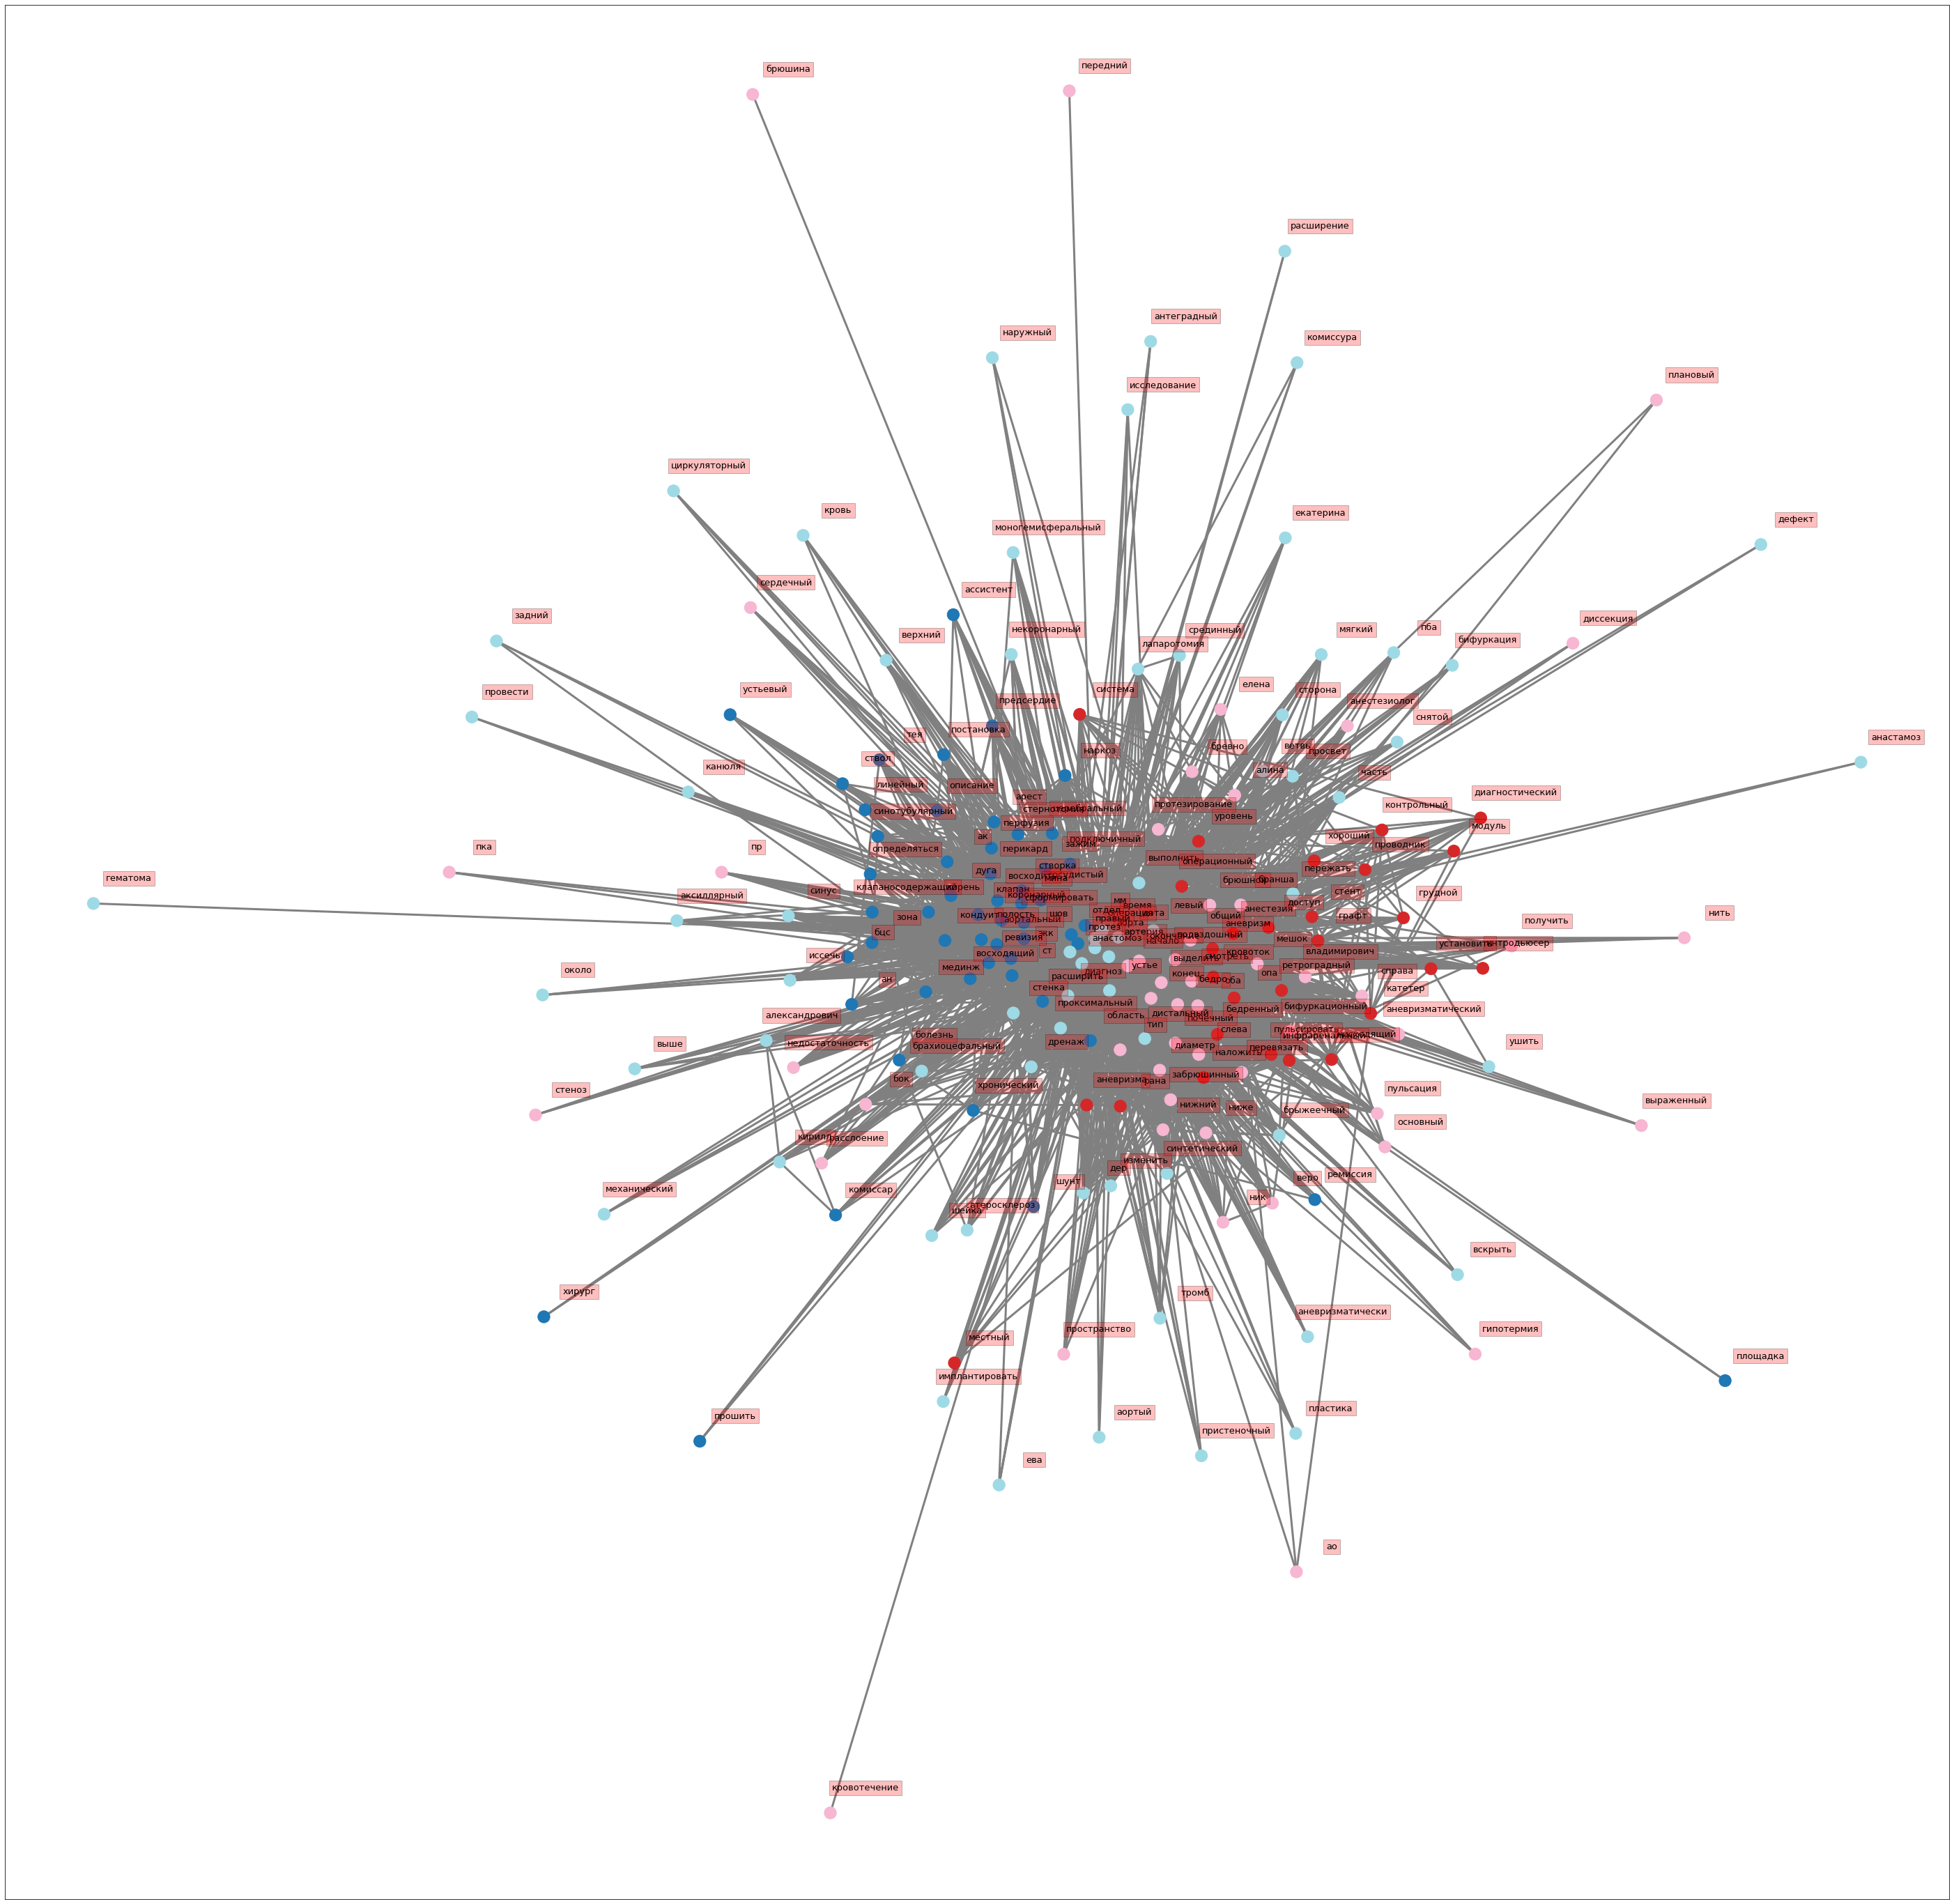

In [19]:
plot_cooccur_graph(word_cooccurrence, frq_threshold=4, cluster_num=4)

In [19]:
texts[0]

'основный ведущий операция резекция инфраренальна аневризм аорта линейный протезирование аорта дата начало операция время начало операция дата окончание операция время окончание операция продолжительность мина плановый анестезия внутривенный наркоз эндотрахеальный наркоз описание операция выполнить доступ абдоминальный аорта выделить общий подвздошный артрии шейк аневризм аневризматический мешок нижний брыжеечный артерия длина аневризм смотреть максимальный ширина смотреть распространяться располагаться ра расстояние приблизительно смотреть почечный артерия расширить выделить взять держалка принять решение выполнение линейный протезирование аорта аневризм выделить подвздошный сосуд пережать пережать ниже отхождение почечный артерия ввести гепариновый замок мешок вскрыть артерия нижний брыжеечный облитерировать отмечаться пульсировать ретроградный кровоток артерия прошить нижний брыжеечный артерия перевязать наложить проксимальный анастомоз наложить дистальный анастомоз забрюшинный прос

In [20]:
#list_to_file('oper_texts.txt', texts, 'cp1251')

# bag-of-words to vowpal wabbit for topic modeling
with open('oper_texts.txt', 'w', encoding='utf-8') as f:
    for t in texts:
        line_file = '|text ' + t + '\n'
        f.write(line_file)

## ARTM Topic Modelling

In [21]:
import warnings
warnings. filterwarnings("ignore", category=DeprecationWarning)
import artm
from numpy import array

#from sklearn.feature_extraction.text import CountVectorizer
#vectorizer = CountVectorizer()
#X = vectorizer.fit_transform(texts)

In [22]:
#cv = CountVectorizer(max_features=100000)
#n_wd = array(cv.fit_transform(texts))
#vocabulary = cv.get_feature_names()

C:\Users\Julia\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
batch_folder = 'my_batches'
batch_vectorizer = artm.BatchVectorizer(
    data_path='oper_texts.txt', 
    data_format="vowpal_wabbit", 
    target_folder=batch_folder, 
    batch_size=500
)

C:\Users\Julia\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
my_dictionary = artm.Dictionary()
my_dictionary.gather(data_path=batch_folder)
my_dictionary

artm.Dictionary(name=9244104f-b114-4353-9daf-56d97530760f, num_entries=3388)

In [24]:
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path=batch_folder,
    symmetric_cooc_values=True)
cooc_dict

artm.Dictionary(name=ec0d6c0e-ea56-4831-86a3-53bfea374ba9, num_entries=3388)

In [45]:
# Model initialization, determining the number of topics
T = 3
main_topics = ["sbj" + str(i) for i in range(T-1)]
extra_topic = "other"
topic_names = main_topics + [extra_topic]

model_artm = artm.ARTM(num_topics=T, 
#                        Список с именами тем
                       topic_names=main_topics + [extra_topic],
                       cache_theta=True
                      )

In [46]:
coherence_score = artm.TopTokensScore(
                            name='TopTokensCoherenceScore',
#                             class_id='@default_class',
                            num_tokens=25,
                            topic_names=topic_names,
                            dictionary=cooc_dict)

In [47]:
# need to add all tracking metrics to the model
# Perplexity - less -> better
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                               dictionary=my_dictionary), overwrite=True)
# The sparsity of the FI matrix is the percentage of zeros in the matrix of the topic word
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'), overwrite=True)
# Theta matrix sparsity - percentage of zeros in the topic-documents matrix
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'), overwrite=True)
# Track terms in each topic
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=25), overwrite=True)
# Coherence score
model_artm.scores.add(coherence_score, overwrite=True)

In [48]:
# Model initialization with data
model_artm.initialize(my_dictionary)

In [49]:
# Model training
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

C:\Users\Julia\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


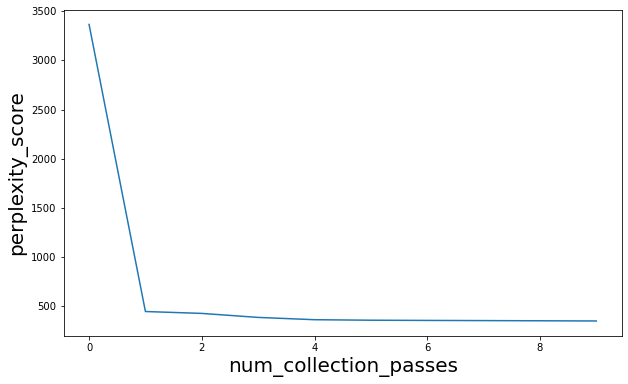

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(model_artm.score_tracker["PerplexityScore"].value)
plt.xlabel('num_collection_passes', fontsize=20)
plt.ylabel('perplexity_score', fontsize=20);

In [51]:
model_artm.score_tracker["PerplexityScore"].value[-1]

351.36053466796875

In [52]:
def topic_metrcis(model_artm, term_print=20):
    # The most significant terms in topics
    for topic_name in model_artm.topic_names:
        these_topics = model_artm.score_tracker['top_words'].last_tokens[topic_name]
        these_topics = map(lambda s: s, these_topics[:term_print])
        print(topic_name, ', '.join(list(these_topics)), sep=' : ')

    # Matrix sparsity
    print()
    print ("SparsityPhiScore", model_artm.score_tracker["SparsityPhiScore"].last_value, sep=' = ')
    print ("SparsityThetaScore", model_artm.score_tracker["SparsityThetaScore"].last_value, sep=' = ')
    print ("CoherenceScore", model_artm.score_tracker["TopTokensCoherenceScore"].average_coherence[-1], sep=' = ')

In [53]:
topic_metrcis(model_artm, 25)

sbj0 : операция, клапан, отдел, протез, дата, аорта, шов, диагноз, время, правый, анестезия, мм, начало, сосудистый, доступ, мина, окончание, восходящий, имплантировать, ушивание, основный, зажим, уровень, арест, левый
sbj1 : аорта, операция, протез, артерия, правый, створка, анастомоз, время, мина, восходить, отдел, коронарный, сосудистый, ст, мм, экк, аортальный, сформировать, перикард, полость, зажим, ревизия, дата, окончание, подключичный
other : артерия, операция, аорта, конец, протез, подвздошный, анастомоз, выделить, смотреть, левый, кровоток, аневризм, дата, общий, окончание, начало, время, бедренный, бедро, почечный, брюшной, правый, мм, оба, отдел

SparsityPhiScore = 0.19805194437503815
SparsityThetaScore = 0.0
CoherenceScore = 0.0


In [54]:
# Smooth regularizer for background topic
model_artm\
    .regularizers\
    .add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', 
                                         tau=1e20, 
                                         topic_names = "other", 
                                         dictionary=my_dictionary), 
         overwrite=True)

In [55]:
# Extra training with regularizer
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)

In [56]:
topic_metrcis(model_artm)

C:\Users\Julia\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


sbj0 : артерия, операция, аорта, конец, левый, подвздошный, смотреть, дата, кровоток, выделить, аневризм, анестезия, общий, окончание, начало, время, анастомоз, бедро, отдел, бедренный
sbj1 : аорта, операция, протез, правый, отдел, время, артерия, мина, сосудистый, анастомоз, створка, мм, дата, шов, восходить, аортальный, ст, экк, коронарный, зажим
other : аорта, операция, артерия, протез, правый, отдел, время, анастомоз, дата, мм, мина, начало, окончание, шов, левый, сосудистый, ст, створка, диагноз, восходить

SparsityPhiScore = 0.3338252604007721
SparsityThetaScore = 0.0
CoherenceScore = 0.0


In [57]:
# Sparse Regularizer for subject topics
model_artm\
    .regularizers\
    .add(artm.SmoothSparsePhiRegularizer(name='SparsePhi',
                                         tau=-1e5, 
                                         topic_names = ["sbj"+str(i) for i in range(T-1)], 
                                         dictionary=my_dictionary), 
         overwrite=True)

In [58]:
# Extra training with regularizer
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)

In [59]:
topic_metrcis(model_artm, 25)

C:\Users\Julia\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


sbj0 : графт, проводник, модуль, интродьюсер, диагностический, позиционировать, удаление, вещество, изоляция, раскрыть, врач, местный, пункция, мскт, антибиотикопрофилактика, ежедневный, аксетина, позвонок, пожизненно, транскатетерный, перевод, сутки, смена, пункционный, аортография
sbj1 : вера, белов, эит, грубый, пликация, швомь, моностворчатый, тахисистолий, динж, орлов, влагалище, аннулоэктазия, мария, укорочение, атриотомный, тичёска, адм, чп, артерийоперация, обратный, зиять, истинно, трансфузиолог, заварзин, гемипарез
other : аорта, операция, артерия, протез, правый, отдел, время, анастомоз, дата, мм, мина, начало, окончание, шов, левый, сосудистый, ст, створка, диагноз, восходить, аортальный, выделить, ревизия, полость, анестезия

SparsityPhiScore = 0.6666666865348816
SparsityThetaScore = 0.5544217824935913
CoherenceScore = 0.0


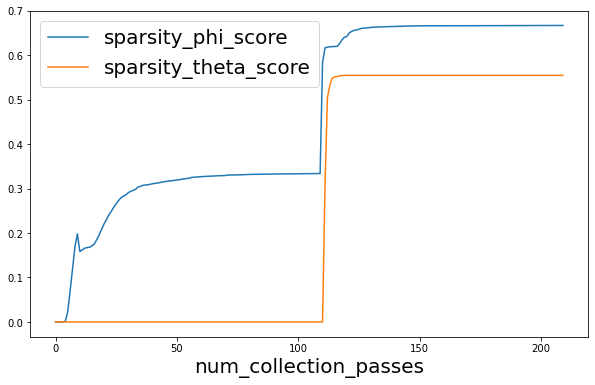

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(model_artm.score_tracker["SparsityPhiScore"].value, label='sparsity_phi_score')
plt.plot(model_artm.score_tracker["SparsityThetaScore"].value, label='sparsity_theta_score')
plt.xlabel('num_collection_passes', fontsize=20)
plt.legend(fontsize=20);

In [61]:
def check_num_topics(num_topics_range):
#     models = []
    scores = {}
    for T in num_topics_range:
        print('topics', T, end='...')
        main_topics = ["sbj" + str(i) for i in range(T-1)]
        extra_topic = "other"
        topic_names = main_topics + [extra_topic]

        model_artm = artm.ARTM(num_topics=T, topic_names=topic_names)
        coherence_score = artm.TopTokensScore(
                            name='TopTokensCoherenceScore',
#                             class_id='@default_class',
                            num_tokens=25,
                            topic_names=topic_names,
                            dictionary=cooc_dict)
        model_artm.scores.add(coherence_score, overwrite=True)
        model_artm.initialize(my_dictionary)
        model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
#         сбор фоновых слов        
        model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', 
                                                                    tau=1e20, 
                                                                    topic_names = "other", 
                                                                    dictionary=my_dictionary), 
                                    overwrite=True)
        model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)
#         разделение тем 
        model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi',
                                         tau=-1e5, 
                                         topic_names = main_topics, 
                                         dictionary=my_dictionary), 
         overwrite=True)
        model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)
        scores[T] = model_artm.score_tracker["TopTokensCoherenceScore"].average_coherence[-1]
    return scores

In [43]:
coh_topics = check_num_topics(range(1, 15))

topics 1...topics 2...topics 3...topics 4...topics 5...topics 6...topics 7...topics 8...topics 9...topics 10...topics 11...topics 12...topics 13...topics 14...

C:\Users\Julia\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


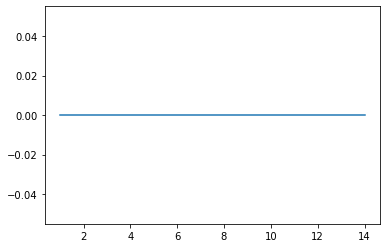

In [44]:
plt.plot(coh_topics.keys(), coh_topics.values())